# Modeling

## Import packages

In [21]:
# !pip install statsmodels

In [49]:
import pandas as pd
import datetime
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', 100)
# pd.set_option('display.max_rows', 300)

## Load Data

In [3]:
stock_price = pd.read_pickle('./stock_price_by_date.pickle')
stock_price['DATE'] = stock_price['DATE'].apply(lambda x: x.strftime('%Y-%m-%d'))
stock_price

,DATE,CLOSING_INDEX
0,2021-06-01,17162.38
1,2021-06-02,17165.04
2,2021-06-03,17246.16
3,2021-06-04,17147.41
4,2021-06-05,17115.66
...,...,...
300,2022-03-28,17520.01
301,2022-03-29,17548.66
302,2022-03-30,17740.56
303,2022-03-31,17693.47


In [4]:
sentiment = pd.read_pickle('./sentiment_by_date.pickle')
sentiment = sentiment.reset_index()
sentiment

,DATE,LIKE,HAHA,LOVE,WOW,CARE,ANGRY,SAD
0,2021-06-01,28224,3022,230,473,194,481,224
1,2021-06-02,22951,709,98,310,50,104,94
2,2021-06-03,22127,1526,203,306,103,266,1486
3,2021-06-04,25506,1257,307,271,117,138,63
4,2021-06-05,12475,406,78,114,25,38,27
...,...,...,...,...,...,...,...,...
299,2022-03-27,71832,23247,453,1422,133,38,113
300,2022-03-28,45144,4684,276,995,570,86,109
301,2022-03-29,61967,4388,408,821,185,90,197
302,2022-03-30,62775,6123,631,1495,242,266,775


In [5]:
df = pd.merge(left=stock_price, right=sentiment, how='left', on='DATE')
df

,DATE,CLOSING_INDEX,LIKE,HAHA,LOVE,WOW,CARE,ANGRY,SAD
0,2021-06-01,17162.38,28224.0,3022.0,230.0,473.0,194.0,481.0,224.0
1,2021-06-02,17165.04,22951.0,709.0,98.0,310.0,50.0,104.0,94.0
2,2021-06-03,17246.16,22127.0,1526.0,203.0,306.0,103.0,266.0,1486.0
3,2021-06-04,17147.41,25506.0,1257.0,307.0,271.0,117.0,138.0,63.0
4,2021-06-05,17115.66,12475.0,406.0,78.0,114.0,25.0,38.0,27.0
...,...,...,...,...,...,...,...,...,...
300,2022-03-28,17520.01,45144.0,4684.0,276.0,995.0,570.0,86.0,109.0
301,2022-03-29,17548.66,61967.0,4388.0,408.0,821.0,185.0,90.0,197.0
302,2022-03-30,17740.56,62775.0,6123.0,631.0,1495.0,242.0,266.0,775.0
303,2022-03-31,17693.47,45174.0,6917.0,879.0,756.0,610.0,269.0,165.0


In [6]:
df = df.loc[df['DATE'].apply(lambda x: '2021-12-01' <= x <= '2022-03-31')]
print(df['DATE'].max())
print(df['DATE'].min())

2022-03-31
2021-12-01


## Granger causality
- The Granger Causality test is used to determine whether or not one time series is useful for forecasting another.
- Examine the different kind of sentiments would can be utilized to predict the stock price
  - If so, how many days we need to observed
  - If not, we can change other sentiment analysis method to extract Facebook sentiment.
- https://www.statology.org/granger-causality-test-in-python/
- https://www.youtube.com/watch?v=4TkNZviNJC0

In [7]:
std = StandardScaler()
columns = ['CLOSING_INDEX', 'LIKE', 'HAHA', 'LOVE', 'WOW', 'CARE', 'ANGRY', 'SAD']
df = pd.DataFrame(std.fit_transform(df[columns]), columns=columns, index=df['DATE'])
df

,CLOSING_INDEX,LIKE,HAHA,LOVE,WOW,CARE,ANGRY,SAD
DATE,,,,,,,,
2021-12-01,-0.807836,-0.881824,-0.669657,-0.334230,-0.341884,-0.637723,-0.473810,-0.343242
2021-12-02,-0.414224,-0.861455,-0.506706,-0.352323,-0.485300,-0.660525,-0.473810,-0.226670
2021-12-03,-0.492838,-0.808711,-0.553602,-0.305493,-0.566134,-0.611664,-0.624865,-0.362425
2021-12-04,-0.505492,-0.953796,-0.617834,-0.361902,-0.593079,-0.673554,-0.380854,-0.278316
2021-12-05,-0.511819,-0.908750,-0.729874,-0.356581,-0.602640,-0.647495,-0.613246,-0.380132
...,...,...,...,...,...,...,...,...
2022-03-27,-0.883630,0.926228,3.405226,-0.155423,0.502095,-0.334785,-0.520289,-0.242901
2022-03-28,-0.994822,0.080806,0.017914,-0.249616,0.130953,1.088697,-0.241419,-0.248804
2022-03-29,-0.913628,0.613725,-0.036099,-0.179370,-0.020286,-0.165400,-0.218179,-0.118951


In [8]:
#perform Granger-Causality test
print('======================= Z_LIKE =======================')
result = grangercausalitytests(df[['CLOSING_INDEX', 'LIKE']], maxlag=5)
print('======================= Z_HAHA =======================')
result = grangercausalitytests(df[['CLOSING_INDEX', 'HAHA']], maxlag=5)
print('======================= Z_LOVE =======================')
result = grangercausalitytests(df[['CLOSING_INDEX', 'LOVE']], maxlag=5)
print('======================= Z_WOW========================')
result = grangercausalitytests(df[['CLOSING_INDEX', 'WOW']], maxlag=5)
print('======================= Z_CARE =======================')
result = grangercausalitytests(df[['CLOSING_INDEX', 'CARE']], maxlag=5)
print('======================= Z_ANGRY =======================')
result = grangercausalitytests(df[['CLOSING_INDEX', 'ANGRY']], maxlag=5)
print('======================= Z_SAD =======================')
result = grangercausalitytests(df[['CLOSING_INDEX', 'SAD']], maxlag=5)

======================= Z_LIKE =======================

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4891  , p=0.0362  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=4.6042  , p=0.0319  , df=1
likelihood ratio test: chi2=4.5180  , p=0.0335  , df=1
parameter F test:         F=4.4891  , p=0.0362  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0771  , p=0.1300  , df_denom=114, df_num=2
ssr based chi2 test:   chi2=4.3364  , p=0.1144  , df=2
likelihood ratio test: chi2=4.2592  , p=0.1189  , df=2
parameter F test:         F=2.0771  , p=0.1300  , df_denom=114, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5143  , p=0.2148  , df_denom=111, df_num=3
ssr based chi2 test:   chi2=4.8293  , p=0.1847  , df=3
likelihood ratio test: chi2=4.7331  , p=0.1924  , df=3
parameter F test:         F=1.5143  , p=0.2148  , df_denom=111, df_num=3

Granger Causality
number of lags (no z

/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DATE', ylabel='VALUE'>

/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


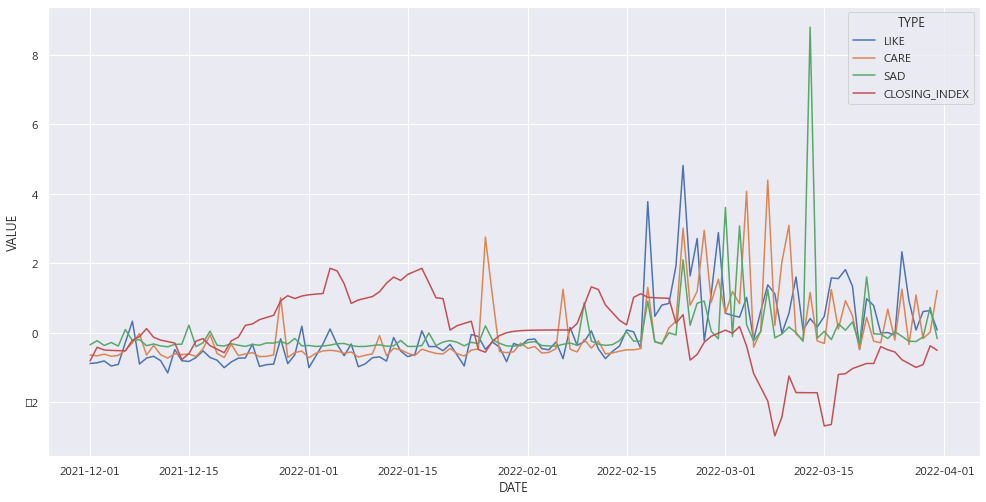

In [9]:
sns.set(rc={'figure.figsize':(16.7,8.27)})
sent_df = df[['LIKE', 'CARE', 'SAD', 'CLOSING_INDEX']].stack().reset_index()
sent_df.columns = ['DATE', 'TYPE', 'VALUE']
sent_df['DATE'] = sent_df['DATE'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
sns.lineplot('DATE', 'VALUE',data = sent_df, hue='TYPE')

## 變數
- Paper
  - 1: 情感預測波動
  - 2: 過去的股價+情感 預測今天的股價
    - QA: 如何抓過去幾天的?
    - Stock Prediction Using Twitter Sentiment Analysis
  - 3: 預測股價還是預測波動
-  To confirm the inverse dependence of other mood dimensions on TWSE we investigated a total of 7 different possibilities.
   - Module 1: $D$
   - Module 2: $D + LIKE$ 
   - Module 3: $D + CARE$
   - Module 4: $D + SAD$
   - Module 4: $D + LIKE + CARE + SAD$
   - Module 5: $D + LIKE + CARE + SAD + HAHA + LOVE + WOW + ANGRY$

In [10]:
stock_price = pd.read_pickle('./stock_price_by_date.pickle')
stock_price['DATE'] = stock_price['DATE'].apply(lambda x: x.strftime('%Y-%m-%d'))
sentiment = pd.read_pickle('./sentiment_by_date.pickle')
df = pd.merge(left=stock_price, right=sentiment, how='left', on='DATE')
df

,DATE,CLOSING_INDEX,LIKE,HAHA,LOVE,WOW,CARE,ANGRY,SAD
0,2021-06-01,17162.38,28224.0,3022.0,230.0,473.0,194.0,481.0,224.0
1,2021-06-02,17165.04,22951.0,709.0,98.0,310.0,50.0,104.0,94.0
2,2021-06-03,17246.16,22127.0,1526.0,203.0,306.0,103.0,266.0,1486.0
3,2021-06-04,17147.41,25506.0,1257.0,307.0,271.0,117.0,138.0,63.0
4,2021-06-05,17115.66,12475.0,406.0,78.0,114.0,25.0,38.0,27.0
...,...,...,...,...,...,...,...,...,...
300,2022-03-28,17520.01,45144.0,4684.0,276.0,995.0,570.0,86.0,109.0
301,2022-03-29,17548.66,61967.0,4388.0,408.0,821.0,185.0,90.0,197.0
302,2022-03-30,17740.56,62775.0,6123.0,631.0,1495.0,242.0,266.0,775.0
303,2022-03-31,17693.47,45174.0,6917.0,879.0,756.0,610.0,269.0,165.0


In [11]:
df.sort_values('SAD')

,DATE,CLOSING_INDEX,LIKE,HAHA,LOVE,WOW,CARE,ANGRY,SAD
172,2021-11-20,17810.9250,10021.0,50.0,56.0,51.0,15.0,6.0,1.0
137,2021-10-16,16743.3250,7422.0,199.0,78.0,45.0,5.0,5.0,3.0
53,2021-07-24,17488.2400,8398.0,133.0,32.0,29.0,13.0,8.0,3.0
131,2021-10-10,16507.2375,4145.0,429.0,27.0,128.0,16.0,4.0,3.0
149,2021-10-28,17041.6300,19709.0,544.0,157.0,110.0,36.0,5.0,3.0
...,...,...,...,...,...,...,...,...,...
267,2022-02-23,18055.7300,194632.0,18431.0,12406.0,2422.0,1160.0,252.0,1701.0
275,2022-03-03,17934.4000,56799.0,10749.0,395.0,7038.0,493.0,524.0,2361.0
273,2022-03-01,17898.2500,60368.0,2061.0,1279.0,1288.0,406.0,322.0,2723.0
285,2022-03-13,17263.4650,55567.0,12248.0,3403.0,685.0,593.0,136.0,6237.0


In [12]:
df['L1D_CLOSING_INDEX'] = df['CLOSING_INDEX'].shift(1)
df['L2D_CLOSING_INDEX'] = df['CLOSING_INDEX'].shift(2)
df['N1D_CLOSING_INDEX'] = df['CLOSING_INDEX'].shift(-1)
df['MOVEMENT'] = df['N1D_CLOSING_INDEX'] - df['CLOSING_INDEX']
df['N1D_CLOSING_DIRE'] = df['MOVEMENT'].apply(lambda x: int(x > 0))
df = df.loc[df['DATE'].apply(lambda x: '2021-12-01' <= x <= '2022-03-31')]
# df = df.loc[df['DATE'].apply(lambda x: '2021-10-01' <= x <= '2022-03-31')]

df = df.reset_index(drop=True)
df

,DATE,CLOSING_INDEX,LIKE,HAHA,LOVE,WOW,CARE,ANGRY,SAD,L1D_CLOSING_INDEX,L2D_CLOSING_INDEX,N1D_CLOSING_INDEX,MOVEMENT,N1D_CLOSING_DIRE
0,2021-12-01,17585.9900,14756.0,916.0,117.0,451.0,40.0,46.0,45.0,17427.760,17328.090,17724.8800,138.8900,1
1,2021-12-02,17724.8800,15399.0,1809.0,83.0,286.0,33.0,46.0,124.0,17585.990,17427.760,17697.1400,-27.7400,0
2,2021-12-03,17697.1400,17064.0,1552.0,171.0,193.0,48.0,20.0,32.0,17724.880,17585.990,17692.6750,-4.4650,0
3,2021-12-04,17692.6750,12484.0,1200.0,65.0,162.0,29.0,62.0,89.0,17697.140,17724.880,17690.4425,-2.2325,0
4,2021-12-05,17690.4425,13906.0,586.0,75.0,151.0,37.0,22.0,20.0,17692.675,17697.140,17688.2100,-2.2325,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2022-03-27,17559.2450,71832.0,23247.0,453.0,1422.0,133.0,38.0,113.0,17598.480,17676.950,17520.0100,-39.2350,0
117,2022-03-28,17520.0100,45144.0,4684.0,276.0,995.0,570.0,86.0,109.0,17559.245,17598.480,17548.6600,28.6500,1
118,2022-03-29,17548.6600,61967.0,4388.0,408.0,821.0,185.0,90.0,197.0,17520.010,17559.245,17740.5600,191.9000,1
119,2022-03-30,17740.5600,62775.0,6123.0,631.0,1495.0,242.0,266.0,775.0,17548.660,17520.010,17693.4700,-47.0900,0


In [13]:
colsing_std = StandardScaler()
colsing_std.fit(df[['CLOSING_INDEX']])
df[['CLOSING_INDEX']] = colsing_std.transform(df[['CLOSING_INDEX']])
df[['L1D_CLOSING_INDEX']] = colsing_std.transform(df[['L1D_CLOSING_INDEX']])
df[['L2D_CLOSING_INDEX']] = colsing_std.transform(df[['L2D_CLOSING_INDEX']])
df[['N1D_CLOSING_INDEX']] = colsing_std.transform(df[['N1D_CLOSING_INDEX']])
df

/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- L1D_CLOSING_INDEX
Feature names seen at fit time, yet now missing:
- CLOSING_INDEX

  warnings.warn(message, FutureWarning)
/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- L2D_CLOSING_INDEX
Feature names seen at fit time, yet now missing:
- CLOSING_INDEX

  warnings.warn(message, FutureWarning)
/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- N1D_CLOSING_INDEX
Feature names 

,DATE,CLOSING_INDEX,LIKE,HAHA,LOVE,WOW,CARE,ANGRY,SAD,L1D_CLOSING_INDEX,L2D_CLOSING_INDEX,N1D_CLOSING_INDEX,MOVEMENT,N1D_CLOSING_DIRE
0,2021-12-01,-0.807836,14756.0,916.0,117.0,451.0,40.0,46.0,45.0,-1.256256,-1.538719,-0.414224,138.8900,1
1,2021-12-02,-0.414224,15399.0,1809.0,83.0,286.0,33.0,46.0,124.0,-0.807836,-1.256256,-0.492838,-27.7400,0
2,2021-12-03,-0.492838,17064.0,1552.0,171.0,193.0,48.0,20.0,32.0,-0.414224,-0.807836,-0.505492,-4.4650,0
3,2021-12-04,-0.505492,12484.0,1200.0,65.0,162.0,29.0,62.0,89.0,-0.492838,-0.414224,-0.511819,-2.2325,0
4,2021-12-05,-0.511819,13906.0,586.0,75.0,151.0,37.0,22.0,20.0,-0.505492,-0.492838,-0.518146,-2.2325,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2022-03-27,-0.883630,71832.0,23247.0,453.0,1422.0,133.0,38.0,113.0,-0.772439,-0.550057,-0.994822,-39.2350,0
117,2022-03-28,-0.994822,45144.0,4684.0,276.0,995.0,570.0,86.0,109.0,-0.883630,-0.772439,-0.913628,28.6500,1
118,2022-03-29,-0.913628,61967.0,4388.0,408.0,821.0,185.0,90.0,197.0,-0.994822,-0.883630,-0.369787,191.9000,1
119,2022-03-30,-0.369787,62775.0,6123.0,631.0,1495.0,242.0,266.0,775.0,-0.913628,-0.994822,-0.503239,-47.0900,0


In [14]:
for col in ['LIKE', 'HAHA', 'LOVE', 'WOW', 'CARE', 'ANGRY', 'SAD']:
    std = StandardScaler()
    df[col] = std.fit_transform(df[[col]])
df

,DATE,CLOSING_INDEX,LIKE,HAHA,LOVE,WOW,CARE,ANGRY,SAD,L1D_CLOSING_INDEX,L2D_CLOSING_INDEX,N1D_CLOSING_INDEX,MOVEMENT,N1D_CLOSING_DIRE
0,2021-12-01,-0.807836,-0.881824,-0.669657,-0.334230,-0.341884,-0.637723,-0.473810,-0.343242,-1.256256,-1.538719,-0.414224,138.8900,1
1,2021-12-02,-0.414224,-0.861455,-0.506706,-0.352323,-0.485300,-0.660525,-0.473810,-0.226670,-0.807836,-1.256256,-0.492838,-27.7400,0
2,2021-12-03,-0.492838,-0.808711,-0.553602,-0.305493,-0.566134,-0.611664,-0.624865,-0.362425,-0.414224,-0.807836,-0.505492,-4.4650,0
3,2021-12-04,-0.505492,-0.953796,-0.617834,-0.361902,-0.593079,-0.673554,-0.380854,-0.278316,-0.492838,-0.414224,-0.511819,-2.2325,0
4,2021-12-05,-0.511819,-0.908750,-0.729874,-0.356581,-0.602640,-0.647495,-0.613246,-0.380132,-0.505492,-0.492838,-0.518146,-2.2325,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2022-03-27,-0.883630,0.926228,3.405226,-0.155423,0.502095,-0.334785,-0.520289,-0.242901,-0.772439,-0.550057,-0.994822,-39.2350,0
117,2022-03-28,-0.994822,0.080806,0.017914,-0.249616,0.130953,1.088697,-0.241419,-0.248804,-0.883630,-0.772439,-0.913628,28.6500,1
118,2022-03-29,-0.913628,0.613725,-0.036099,-0.179370,-0.020286,-0.165400,-0.218179,-0.118951,-0.994822,-0.883630,-0.369787,191.9000,1
119,2022-03-30,-0.369787,0.639320,0.280498,-0.060697,0.565545,0.020271,0.804345,0.733948,-0.913628,-0.994822,-0.503239,-47.0900,0


## 模型
- Model
  - Regression
    - LR
    - SVR
    - MAP
  - Classfication
    - Logistic Regression
    - SVM
    - MAP
    - SOFNN
- KSVC

### Regression

#### N1D_CLOSING_INDEX

In [37]:
module1 = ['L2D_CLOSING_INDEX', 'L1D_CLOSING_INDEX', 'CLOSING_INDEX']
module2 = ['L2D_CLOSING_INDEX', 'L1D_CLOSING_INDEX', 'CLOSING_INDEX', 'LIKE']
module3 = ['L2D_CLOSING_INDEX', 'L1D_CLOSING_INDEX', 'CLOSING_INDEX', 'CARE']
module4 = ['L2D_CLOSING_INDEX', 'L1D_CLOSING_INDEX', 'CLOSING_INDEX', 'SAD']
module5 = ['L2D_CLOSING_INDEX', 'L1D_CLOSING_INDEX', 'CLOSING_INDEX', 'LIKE', 'CARE', 'SAD']
module6 = ['L2D_CLOSING_INDEX', 'L1D_CLOSING_INDEX', 'CLOSING_INDEX', 'LIKE', 'CARE', 'SAD', 'HAHA', 'LOVE', 'WOW', 'ANGRY']
target = ['N1D_CLOSING_INDEX']

In [38]:
df.columns

Index(['DATE', 'CLOSING_INDEX', 'LIKE', 'HAHA', 'LOVE', 'WOW', 'CARE', 'ANGRY',
       'SAD', 'L1D_CLOSING_INDEX', 'L2D_CLOSING_INDEX', 'N1D_CLOSING_INDEX',
       'MOVEMENT', 'N1D_CLOSING_DIRE'],
      dtype='object')

In [39]:
split_date = '2022-02-28'
training = df.loc[df['DATE'] <= split_date]
testing = df.loc[df['DATE'] > split_date]
print(training.shape)
print(testing.shape)

(90, 14)
(31, 14)


In [40]:
regressor = LinearRegression()
regressor.fit(training[module1], training[target])
print(regressor.score(training[module1], training[target]))
print(regressor.score(testing[module1], testing[target]))

0.8247657250549724
0.5377552926989231


In [41]:
regressor = LinearRegression()
regressor.fit(training[module2], training[target])
print(regressor.score(training[module2], training[target]))
print(regressor.score(testing[module2], testing[target]))

0.8324064310269387
0.577149297181325


In [42]:
regressor = LinearRegression()
regressor.fit(training[module3], training[target])
print(regressor.score(training[module3], training[target]))
print(regressor.score(testing[module3], testing[target]))

0.8279936309830995
0.592761523446129


In [43]:
regressor = LinearRegression()
regressor.fit(training[module4], training[target])
print(regressor.score(training[module4], training[target]))
print(regressor.score(testing[module4], testing[target]))

0.8316182991470321
0.5252056267017035


In [44]:
regressor = LinearRegression()
regressor.fit(training[module5], training[target])
print(regressor.score(training[module5], training[target]))
print(regressor.score(testing[module5], testing[target]))

0.8334627429147654
0.5711699855227276


In [45]:
regressor = LinearRegression()
regressor.fit(training[module6], training[target])
print(regressor.score(training[module6], training[target]))
print(regressor.score(testing[module6], testing[target]))

0.8391809860192471
0.5360391437071822


In [48]:
training

,DATE,CLOSING_INDEX,LIKE,HAHA,LOVE,WOW,CARE,ANGRY,SAD,L1D_CLOSING_INDEX,L2D_CLOSING_INDEX,N1D_CLOSING_INDEX,MOVEMENT,N1D_CLOSING_DIRE
0,2021-12-01,-0.807836,-0.881824,-0.669657,-0.334230,-0.341884,-0.637723,-0.473810,-0.343242,-1.256256,-1.538719,-0.414224,138.89000,1
1,2021-12-02,-0.414224,-0.861455,-0.506706,-0.352323,-0.485300,-0.660525,-0.473810,-0.226670,-0.807836,-1.256256,-0.492838,-27.74000,0
2,2021-12-03,-0.492838,-0.808711,-0.553602,-0.305493,-0.566134,-0.611664,-0.624865,-0.362425,-0.414224,-0.807836,-0.505492,-4.46500,0
3,2021-12-04,-0.505492,-0.953796,-0.617834,-0.361902,-0.593079,-0.673554,-0.380854,-0.278316,-0.492838,-0.414224,-0.511819,-2.23250,0
4,2021-12-05,-0.511819,-0.908750,-0.729874,-0.356581,-0.602640,-0.647495,-0.613246,-0.380132,-0.505492,-0.492838,-0.518146,-2.23250,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2022-02-24,-0.783577,1.636447,-0.320580,-0.203317,4.843677,0.792274,1.245889,0.217487,0.523399,0.278430,-0.620254,57.63000,1
86,2022-02-25,-0.620254,2.713625,0.479033,0.456034,0.349987,1.192934,1.635145,0.853472,-0.783577,0.523399,-0.271575,123.03500,1
87,2022-02-26,-0.271575,-0.235308,0.410969,-0.155423,-0.465309,2.948671,0.432518,0.912496,-0.620254,-0.783577,-0.097236,61.51750,1
88,2022-02-27,-0.097236,1.130994,-0.459262,0.011677,-0.160225,0.883481,-0.392473,0.041890,-0.271575,-0.620254,-0.010066,30.75875,1


In [50]:
# statmodels
training2 = training[module3]
training2 = sm.add_constant(training2, prepend=False)

# Fit and summarize OLS model
mod = sm.OLS(training[target], training2)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      N1D_CLOSING_INDEX   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     102.3
Date:                Mon, 18 Apr 2022   Prob (F-statistic):           1.17e-31
Time:                        13:12:41   Log-Likelihood:                -17.165
No. Observations:                  90   AIC:                             44.33
Df Residuals:                      85   BIC:                             56.83
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
L2D_CLOSING_INDEX    -0.0140      0.10

#### MOVEMENT
- 練習改成預測變化的量

In [ ]:
# df.loc[df['DATE'].apply(lambda x: '2021-12-01'<=x<='2022-02-28')]['N1D_CLOSING_DIRE'].value_counts()
# df.loc[df['DATE'].apply(lambda x: '2022-03-01'<=x<='2022-03-31')]['N1D_CLOSING_DIRE'].value_counts()

In [ ]:
# reg = LinearRegression()
# reg.fit(training[['LIKE']], training['MOVEMENT'])
# print(reg.score(training[['LIKE']], training['MOVEMENT']))
# print(reg.score(testing[['LIKE']], testing['MOVEMENT']))

# training['PRED'] = reg.predict(training[['LIKE']])
# print(mean_absolute_percentage_error(training[['LIKE']], training['PRED']))
# testing['PRED']  = reg.predict(testing[['LIKE']])
# print(mean_absolute_percentage_error(testing['MOVEMENT'], testing['PRED']))

In [ ]:
# module1 = ['CLOSING_INDEX']
# module2 = ['CLOSING_INDEX', 'LIKE']
# module3 = ['CLOSING_INDEX', 'CARE']
# module4 = ['CLOSING_INDEX', 'SAD']
# module5 = ['CLOSING_INDEX', 'LIKE', 'CARE', 'SAD']
# module6 = ['CLOSING_INDEX', 'LIKE', 'CARE', 'SAD', 'HAHA', 'LOVE', 'WOW', 'ANGRY']
# target = ['N1D_CLOSING_INDEX']

### Classification
- 練習改成用分類模型，MOVEMENT_DIRECT

## Visualization

<AxesSubplot:xlabel='DATE', ylabel='VALUE'>

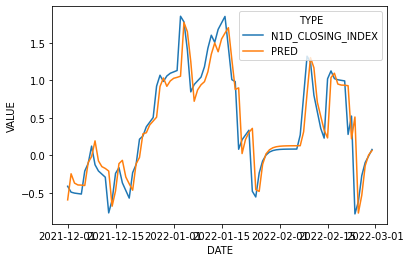

In [243]:
tmpdf = training[['DATE', 'N1D_CLOSING_INDEX', 'PRED']]
tmpdf = tmpdf.set_index('DATE').stack().reset_index()
tmpdf.columns = ['DATE', 'TYPE', 'VALUE']
tmpdf['DATE'] = tmpdf['DATE'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
sns.lineplot(x='DATE', y = 'VALUE', data=tmpdf, hue='TYPE')

<AxesSubplot:xlabel='DATE', ylabel='VALUE'>

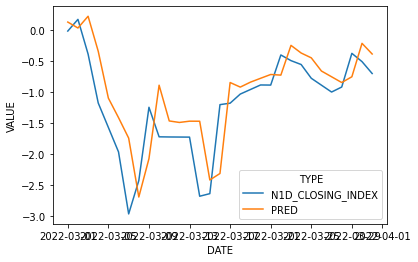

In [244]:
tmpdf = testing[['DATE', 'N1D_CLOSING_INDEX', 'PRED']]
tmpdf = tmpdf.set_index('DATE').stack().reset_index()
tmpdf.columns = ['DATE', 'TYPE', 'VALUE']
tmpdf['DATE'] = tmpdf['DATE'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
sns.lineplot(x='DATE', y = 'VALUE', data=tmpdf, hue='TYPE')